In [ ]:
# Code for the Book: International Stock Picking A.I. INVESTOR: A Guide to Build.
# Website: ai-investor.net
# Code needs am "All-In-One" subscription from the (presumably) nice people at https://eodhistoricaldata.com/. 
# Check the book text to see if they have changed their service since mid-2021.

# Damon Lee 2021

# Feel free to fork this code for others to see what can be done with it.

In [1]:
myToken = 'ABC123.XXXXXX.84098767' # Own token from EODHistoricalData

# Final Stock Picks for the A.I. Investor

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Set the plotting DPI settings to be a bit higher.
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

In [3]:
# from myFunctions want to import for
# calcZScores
# newSKLearnRegressorModelAndPrediction
# fundamentalStockPicker

from myFunctions import *

In [4]:
# Want this data to get stock and price information 
stockData=pd.read_csv('stockData_2021.csv')
stockData['date']=pd.to_datetime(stockData['date'])
priceData = pd.read_csv('priceData_2021.csv', index_col=0)
priceData=priceData[~priceData.index.duplicated()]

X_presentDay=pd.read_csv('AnnualStockFeatures_presentDayStockSelection_2021.csv', 
                         index_col=0)
y_presentDay=pd.read_csv('AnnualStockPerformance_presentDayStockSelection_2021.csv', 
                         index_col=0)

print('priceData DataFrame shape', priceData.shape)
print('stockData DataFrame shape', stockData.shape)
print('X_presentDay DataFrame shape', X_presentDay.shape)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,10,12,14,22,23,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


priceData DataFrame shape (536960, 15)
stockData DataFrame shape (536960, 152)
X_presentDay DataFrame shape (273947, 19)


# Without Modern Portfolio Theory USA Example

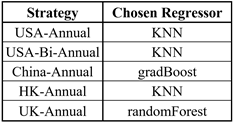

In [49]:
# Takes a few seconds
results = fundamentalStockPicker('2021-01-01', '2021-06-16', # selects stocks with annual reports between these dates
                                   X_presentDay, y_presentDay, # Training Data
                                   stockData, priceData, # Stock Data
                                   country='USA',
                                   zScore=2.6, # Z score cut-off to remove risky companies
                                   modelName='KNN', # Regressor model used
                                   numberOfStocks=10) # Number of stocks to choose

results[['Prediction','Code','Exchange','buyDate','buyPrice','zScore']]

,Prediction,Code,Exchange,buyDate,buyPrice,zScore
467076,0.903676,SNEX,NASDAQ,2021-01-28,54.76,4.283461
202982,0.829222,BVH,NYSE,2021-04-30,18.52,8.360052
277318,0.792940,FOSL,NASDAQ,2021-04-30,12.90,9.677940
276170,0.639117,FNCH,NASDAQ,2021-04-30,14.00,2.966258
371247,0.631269,MLR,NYSE,2021-04-30,43.02,10.115397
317156,0.630116,IEA,NASDAQ,2021-04-30,13.18,2.834053
521647,0.624030,WDH,NYSE,2021-05-06,12.00,7.774389
260321,0.623499,ENLC,NYSE,2021-04-30,4.63,3.086229
281580,0.622092,FVE,NASDAQ,2021-04-30,5.21,3.418136
251980,0.612696,EAR,NASDAQ,2021-04-30,57.24,10.073576


# HK Example

In [311]:
# Takes a few seconds
results = fundamentalStockPicker('2021-01-01', '2021-06-16',
                                   X_presentDay, y_presentDay,
                                   stockData, priceData,
                                   country='Hong Kong',
                                   zScore=2.6,
                                   modelName='KNN')

results[['Prediction','Code','Exchange','buyDate','buyPrice','zScore']]

,Prediction,Code,Exchange,buyDate,buyPrice,zScore
63315,0.735979,2728,HK,2021-04-30,0.149,3.870928
50911,0.646562,1901,HK,2021-04-30,0.890,2.943635
48449,0.635608,1692,HK,2021-04-30,2.260,10.895051
31733,0.614808,0834,HK,2021-04-30,0.370,4.336890
137668,0.596043,8426,HK,2021-04-30,0.158,11.503934
136056,0.584275,8191,HK,2021-04-30,0.173,2.962173
135150,0.582400,8106,HK,2021-04-30,0.150,10.718579
26728,0.579977,0630,HK,2021-04-30,0.135,9.406318
26274,0.579614,0607,HK,2021-04-30,0.163,4.470450
77209,0.578145,3322,HK,2021-04-30,0.335,5.867858


# Naive Modern Portfolio Theory Example

In [143]:
def calcPortWeightsMPT(dateStart, dateEnd, 
                       listOfTickersToAdd,
                       MPT=True, 
                       pickedStockPredReturns=False,
                       MPTMaxWeighting=0.2,
                       riskFreeRate=0.05,
                       myToken=None):
    '''
    Calculate the time series of the backtest portfolio for one period.
    Makes API calls to EODHistoricalData to get price series for component stocks 
    Normalises stock price series to start at 1.
    Takes a daily average to find portfolio value over time.
    Returns a DataFrame of the optimal stock weights.
    '''
    currentWindowStockValues = pd.DataFrame(index=pd.date_range(dateStart, 
                                                                dateEnd))
    
    for ticker in listOfTickersToAdd:
        currentWindowStockValues[ticker] = \
        get_eod_data(dateStart, dateEnd, 
                     symbol=ticker, 
                     api_token=myToken)['Adjusted_close']
        
        # forwardfill to get daily price no discontinuities.
        currentWindowStockValues[ticker].ffill(inplace=True) 
    
    currentWindowStockValues.bfill(inplace=True) # backfill missing prices.
    currentWindowStockValuesRelative = \
                    getPortfolioRelativeTimeSeries(currentWindowStockValues)
    
    # Modern portfolio theory, 
    # use previous period price series to find correlation.
    if MPT: 
        prevWindowStockValues = pd.DataFrame(\
                         index=pd.date_range(dateStart+(dateStart-dateEnd), 
                                             dateStart)) # past period corr.
        
        for ticker in listOfTickersToAdd:
            prevWindowStockValues[ticker] = \
                                get_eod_data(dateStart+(dateStart-dateEnd),
                                             dateStart,
                                             symbol=ticker,
                                             api_token=myToken)['Adjusted_close']
            
            prevWindowStockValues[ticker].ffill(inplace=True)
            
        prevWindowStockValues.bfill(inplace=True)
        
        prevWindowStockValuesRelative = \
                            getPortfolioRelativeTimeSeries(prevWindowStockValues)
        
        prevWindowStockValuesRelative.drop(columns='Portfolio', inplace=True)
        currentWindowStockValuesRelative.drop(columns='Portfolio', inplace=True)
        
        
        # Make the calls to optimisePortfolioMPT to get optimal portfolio weights     
        weights = list(np.round(\
                            optimisePortfolioMPT(prevWindowStockValuesRelative, 
                                                 pickedStockPredReturns,
                                                 maxWeight=MPTMaxWeighting, 
                                                 risk_free_rate=riskFreeRate), 
                                3))
           
        return weights

In [274]:
# First pick the stocks
results = fundamentalStockPicker('2021-01-01', '2021-06-16',
                                 X_presentDay, y_presentDay,
                                 stockData, priceData,
                                 country='USA', # feel free to change
                                 zScore=2.6,
                                 modelName='KNN',
                                 numberOfStocks=16)

# Make the list of stock tickers
listOfTickersToAdd = list(results['Code'].astype(str)+'.'+'US')#results['Exchange'])
print('List of tickers to add is: ', listOfTickersToAdd)

List of tickers to add is:  ['SNEX.US', 'BVH.US', 'FOSL.US', 'FNCH.US', 'MLR.US', 'IEA.US', 'WDH.US', 'ENLC.US', 'FVE.US', 'EAR.US', 'IKNA.US', 'SRLP.US', 'VYGR.US', 'DSGN.US', 'FREQ.US', 'WINA.US']


In [275]:
# Estimate stock return 10%
listOfPredictedReturns = [1.1] * len(listOfTickersToAdd)

# Optional, add ETFs for exposure to gold and bonds
results = results.append({'Code':'GLD'},ignore_index=True)
results = results.append({'Code':'SPLB'},ignore_index=True)
listOfTickersToAdd.append('GLD.US')
listOfTickersToAdd.append('SPLB.US')
# Estimate Gold return over 50 years
listOfPredictedReturns.append(1.07) 
# Estimate Bond fund return since inception ~2009
listOfPredictedReturns.append(1.06) 

print('List of predicted returns is: ', listOfPredictedReturns)

List of predicted returns is:  [1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.07, 1.06]


In [309]:
# Get the MPT stock weighting
# takes a few seconds
MPTWeighting = calcPortWeightsMPT(pd.to_datetime('2021-01-01')-pd.Timedelta(weeks=1), 
                                  pd.to_datetime('2022-06-01'), 
                                  listOfTickersToAdd,
                                  MPT=True, 
                                  pickedStockPredReturns=listOfPredictedReturns,
                                  MPTMaxWeighting=0.2,
                                  riskFreeRate=0.06,
                                  myToken=myToken)

# Put the weighting into our final stock selection
results['MPTWeighting'] = MPTWeighting
results[['Prediction','Code','Exchange','buyDate','buyPrice','zScore','MPTWeighting']]

,Prediction,Code,Exchange,buyDate,buyPrice,zScore,MPTWeighting
0,0.903676,SNEX,NASDAQ,2021-01-28,54.76,4.283461,0.000
1,0.829222,BVH,NYSE,2021-04-30,18.52,8.360052,0.000
2,0.792940,FOSL,NASDAQ,2021-04-30,12.90,9.677940,0.000
3,0.639117,FNCH,NASDAQ,2021-04-30,14.00,2.966258,0.200
4,0.631269,MLR,NYSE,2021-04-30,43.02,10.115397,0.020
5,0.630116,IEA,NASDAQ,2021-04-30,13.18,2.834053,0.000
6,0.624030,WDH,NYSE,2021-05-06,12.00,7.774389,0.200
7,0.623499,ENLC,NYSE,2021-04-30,4.63,3.086229,0.000
8,0.622092,FVE,NASDAQ,2021-04-30,5.21,3.418136,0.000
9,0.612696,EAR,NASDAQ,2021-04-30,57.24,10.073576,0.013


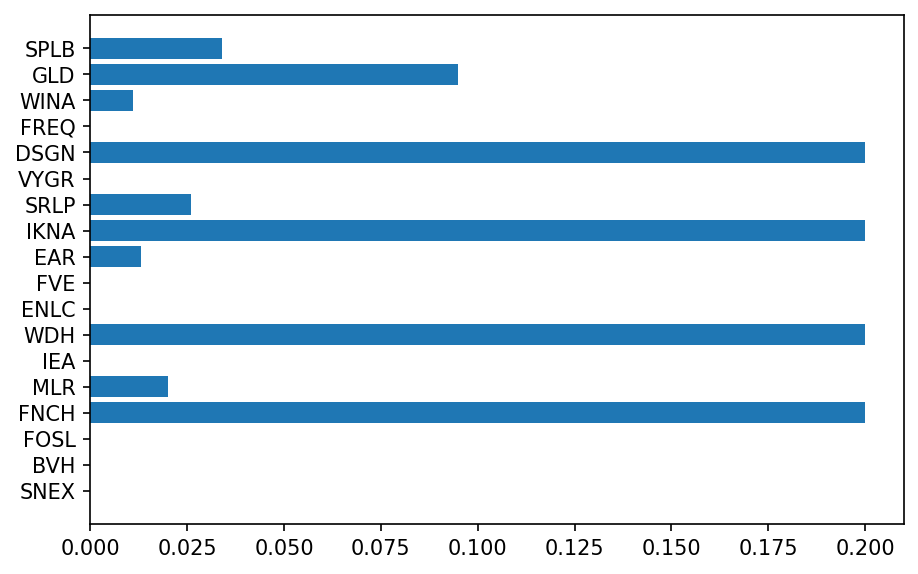

In [310]:
plt.barh(results['Code'].astype(str), 
         width=results['MPTWeighting']);

<AxesSubplot:xlabel='Date'>

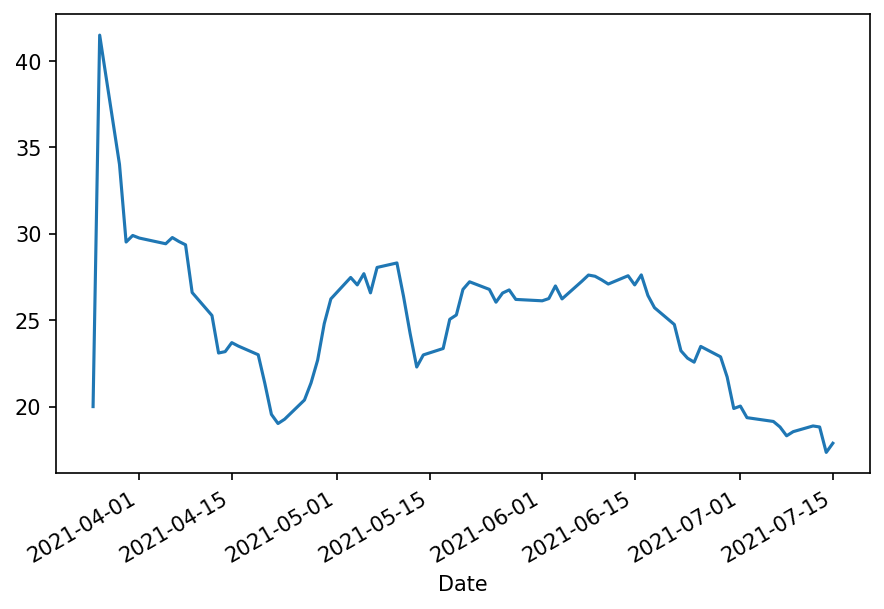

In [312]:
# Issue when the stock price time series doesn't go back in time far enough.
# MPT doesn't work if it's a new stock and there's no correlation information.
# e.g. DSGN here. Explains why it got the full MPT allocaiton of 20%. 
# Luckily this didn't happen with other stock markets, so we will continue.

# Check that there is price history for some stocks
a = get_eod_data('2016-04-30','2022-09-09',symbol='DSGN.US', api_token=myToken)
a['Adjusted_close'].plot()

### Put above into one function with stock selection

In [145]:
def fundamentalStockPickerWithMPT(startDate, endDate,
                                  X_presentDay, y_presentDay,
                                  stockData, priceData,
                                  country='USA',
                                  zScore=2.6,
                                  modelName='KNN',
                                  numberOfStocks=16,
                                  correlationWeeks=52,
                                  riskFreeRate=0.05):
    '''
    runs fundamentalStockPicker and calcPortWeightsMPT
    returns the stock pics as well as the MPT allocation
    as cut-down results DataFrame
    
    MPT uses correlation from last 1 years by default
    '''
    
    results = fundamentalStockPicker(startDate, endDate,
                                     X_presentDay, y_presentDay,
                                     stockData, priceData,
                                     country=country,
                                     zScore=zScore,
                                     modelName=modelName,
                                     numberOfStocks=numberOfStocks)
    
    # Make the list of stock tickers
    if country=='USA':
        listOfTickersToAdd = list(results['Code'].astype(str)+'.US')
    else:
        listOfTickersToAdd = list(results['Code'].astype(str)+'.'+results['Exchange'])
                                  
    print('List of tickers to add is: ', listOfTickersToAdd)
    
    # Estimate stock return 10%
    listOfPredictedReturns = [1.1] * len(listOfTickersToAdd)

    # Optional, add ETFs for exposure to gold and bonds
    results = results.append({'Code':'GLD'},ignore_index=True)
    results = results.append({'Code':'SPLB'},ignore_index=True)
    listOfTickersToAdd.append('GLD.US')
    listOfTickersToAdd.append('SPLB.US')
    # Estimate Gold return over 50 years
    listOfPredictedReturns.append(1.07) 
    # Estimate Bond fund return since inception ~2009
    listOfPredictedReturns.append(1.06) 

    print('List of predicted returns is: ', listOfPredictedReturns)
    
    # Get the MPT stock weighting
    # takes a few seconds
    MPTWeighting = calcPortWeightsMPT(pd.to_datetime(endDate)-pd.Timedelta(weeks=correlationWeeks), 
                                      pd.to_datetime(endDate), 
                                      listOfTickersToAdd,
                                      MPT=True, 
                                      pickedStockPredReturns=listOfPredictedReturns,
                                      MPTMaxWeighting=0.2,
                                      riskFreeRate=riskFreeRate,
                                      myToken=myToken) 

    # Put the weighting into our final stock selection
    results['MPTWeighting'] = MPTWeighting
    
    return results[['Prediction','Code','Exchange','buyDate','buyPrice','zScore','MPTWeighting']]

# A.I. Investor Stock Selection for Various Markets Mid-2021
## With Naive MPT Output

In [160]:
# USA With MPT
results = fundamentalStockPickerWithMPT('2021-01-01', '2021-06-16',
                                        X_presentDay, y_presentDay,
                                        stockData, priceData,
                                        country='USA',
                                        zScore=2.6,
                                        modelName='KNN',
                                        correlationWeeks=4,
                                        riskFreeRate=0.06)

results

List of tickers to add is:  ['SNEX.US', 'BVH.US', 'FOSL.US', 'FNCH.US', 'MLR.US', 'IEA.US', 'WDH.US', 'ENLC.US', 'FVE.US', 'EAR.US', 'IKNA.US', 'SRLP.US', 'VYGR.US', 'DSGN.US', 'FREQ.US', 'WINA.US']
List of predicted returns is:  [1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.07, 1.06]


,Prediction,Code,Exchange,buyDate,buyPrice,zScore,MPTWeighting
0,0.903676,SNEX,NASDAQ,2021-01-28,54.76,4.283461,0.096
1,0.829222,BVH,NYSE,2021-04-30,18.52,8.360052,0.014
2,0.792940,FOSL,NASDAQ,2021-04-30,12.90,9.677940,0.000
3,0.639117,FNCH,NASDAQ,2021-04-30,14.00,2.966258,0.162
4,0.631269,MLR,NYSE,2021-04-30,43.02,10.115397,0.200
5,0.630116,IEA,NASDAQ,2021-04-30,13.18,2.834053,0.000
6,0.624030,WDH,NYSE,2021-05-06,12.00,7.774389,0.000
7,0.623499,ENLC,NYSE,2021-04-30,4.63,3.086229,0.000
8,0.622092,FVE,NASDAQ,2021-04-30,5.21,3.418136,0.063
9,0.612696,EAR,NASDAQ,2021-04-30,57.24,10.073576,0.005


In [163]:
# China with MPT
results = fundamentalStockPickerWithMPT('2021-01-01', '2021-06-16',
                                        X_presentDay, y_presentDay,
                                        stockData, priceData,
                                        country='China',
                                        zScore=2.6,
                                        modelName='gradBoost',
                                        correlationWeeks=4,
                                        riskFreeRate=0.06

results

List of tickers to add is:  ['200152.SHE', '600616.SHG', '603003.SHG', '300175.SHE', '300836.SHE', '603730.SHG', '603787.SHG', '603087.SHG', '600981.SHG', '300184.SHE', '900925.SHG', '603517.SHG', '900912.SHG', '601339.SHG', '600960.SHG', '300642.SHE']
List of predicted returns is:  [1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.07, 1.06]


,Prediction,Code,Exchange,buyDate,buyPrice,zScore,MPTWeighting
0,1.115373,200152,SHE,2021-04-30,5.380,2.951953,0.000
1,1.112312,600616,SHG,2021-04-30,7.160,14.736468,0.004
2,0.811946,603003,SHG,2021-04-30,6.790,15.317509,0.000
3,0.776453,300175,SHE,2021-05-12,4.750,6.142451,0.000
4,0.719704,300836,SHE,2021-04-30,35.270,11.870777,0.165
5,0.678965,603730,SHG,2021-04-30,22.590,10.330747,0.000
6,0.634210,603787,SHG,2021-04-30,18.380,5.228614,0.000
7,0.613798,603087,SHG,2021-04-30,134.700,26.284590,0.200
8,0.598057,600981,SHG,2021-04-30,2.810,4.952326,0.002
9,0.577593,300184,SHE,2021-04-30,3.760,4.801238,0.000


In [223]:
# Hong Kong with MPT
results = fundamentalStockPickerWithMPT('2021-01-01', '2021-06-16',
                                        X_presentDay, y_presentDay,
                                        stockData, priceData,
                                        country='Hong Kong',
                                        zScore=2.6,
                                        modelName='KNN',                                        
                                        correlationWeeks=52,
                                        riskFreeRate=0.06)

results

List of tickers to add is:  ['2728.HK', '1901.HK', '1692.HK', '0834.HK', '8426.HK', '8191.HK', '8106.HK', '0630.HK', '0607.HK', '3322.HK', '3378.HK', '8348.HK', '2009.HK', '3636.HK', '1733.HK', '2323.HK']
List of predicted returns is:  [1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.07, 1.06]


,Prediction,Code,Exchange,buyDate,buyPrice,zScore,MPTWeighting
0,0.735979,2728,HK,2021-04-30,0.149,3.870928,0.062
1,0.646562,1901,HK,2021-04-30,0.890,2.943635,0.018
2,0.635608,1692,HK,2021-04-30,2.260,10.895051,0.000
3,0.614808,0834,HK,2021-04-30,0.370,4.336890,0.077
4,0.596043,8426,HK,2021-04-30,0.158,11.503934,0.095
5,0.584275,8191,HK,2021-04-30,0.173,2.962173,0.036
6,0.582400,8106,HK,2021-04-30,0.150,10.718579,0.166
7,0.579977,0630,HK,2021-04-30,0.135,9.406318,0.044
8,0.579614,0607,HK,2021-04-30,0.163,4.470450,0.042
9,0.578145,3322,HK,2021-04-30,0.335,5.867858,0.056


In [215]:
# UK with MPT
results = fundamentalStockPickerWithMPT('2021-01-01', '2021-06-16',
                                        X_presentDay, y_presentDay,
                                        stockData, priceData,
                                        country='UK',
                                        zScore=2.6,
                                        modelName='randomForest',                                        
                                        correlationWeeks=52*5,
                                        riskFreeRate=0.05)

results

List of tickers to add is:  ['BONH.LSE', 'PLUS.LSE', 'WBI.LSE', 'PPH.LSE', 'CGI.LSE', 'BHMU.LSE', 'ZAM.LSE', 'PAGE.LSE', 'INDV.LSE', 'PRTC.LSE', 'SHOE.LSE', 'TRU.LSE', 'CMCL.LSE', 'GCS.LSE', 'JIM.LSE', 'ARO.LSE']
List of predicted returns is:  [1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.07, 1.06]


,Prediction,Code,Exchange,buyDate,buyPrice,zScore,MPTWeighting
0,1.121868,BONH,LSE,2021-04-30,16.590,7.186799,0.002
1,0.982862,PLUS,LSE,2021-04-30,1420.000,26.740603,0.004
2,0.718905,WBI,LSE,2021-04-30,7.700,6.022037,0.004
3,0.653034,PPH,LSE,2021-04-30,1694.000,3.611159,0.007
4,0.575618,CGI,LSE,2021-04-30,997.500,15.833961,0.012
5,0.567187,BHMU,LSE,2021-04-30,34.700,24.258491,0.200
6,0.565064,ZAM,LSE,2021-01-28,5.625,23.269773,0.006
7,0.551265,PAGE,LSE,2021-04-30,560.500,7.382116,0.016
8,0.540278,INDV,LSE,2021-04-30,152.600,7.947213,0.016
9,0.503762,PRTC,LSE,2021-04-30,415.000,7.604952,0.072
